<a href="https://colab.research.google.com/github/C3578/5k_yogurt_classification/blob/master/5k_yogurt_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
print(os.getcwd())

/content


In [ ]:
data_root = '...'
print(os.listdir(data_root))

['data', 'test']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'data'
val_dir = 'val'

class_names = ['35_curd_raisins', '36_curd_strawberry', '37_curd_cereals', '42_cup_yogurt_peach', '43_cup_yogurt_blackberry']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'data', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 974/974 [00:02<00:00, 449.72it/s]


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
len(train_dataloader), len(train_dataset)

(484, 3868)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


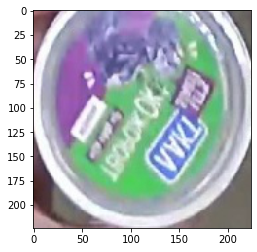

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)

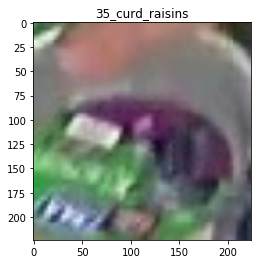

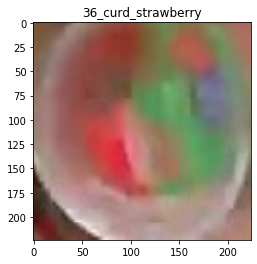

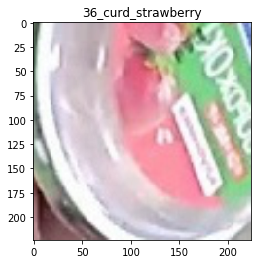

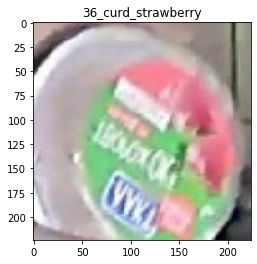

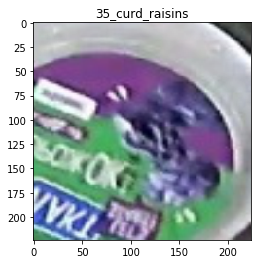

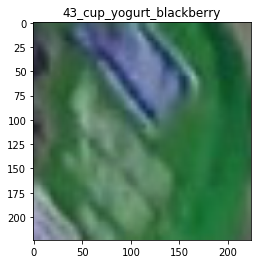

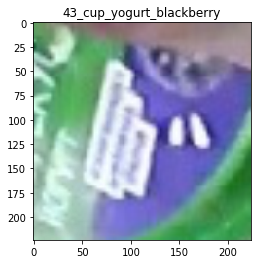

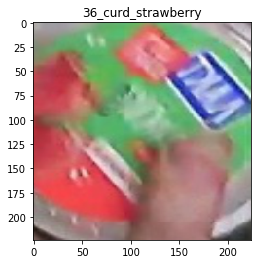

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  
            else:
                dataloader = val_dataloader
                model.eval()   

            running_loss = 0.
            running_acc = 0.

            
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=2); #num_epochs=100

Epoch 0/1:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 484/484 [06:19<00:00,  1.51it/s]

train Loss: 0.9738 Acc: 0.6493



100%|██████████| 98/98 [01:07<00:00,  1.95it/s]

val Loss: 0.4641 Acc: 0.8967
Epoch 1/1:



100%|██████████| 484/484 [06:16<00:00,  1.51it/s]

train Loss: 0.6263 Acc: 0.7859



100%|██████████| 98/98 [01:07<00:00,  2.01it/s]

val Loss: 0.4219 Acc: 0.8686


In [ ]:
test_dir = 'test'

In [ ]:
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [ ]:
#shutil.copytree(os.path.join(data_root, 'test'), os.path.join(data_root, 'unknown'))

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test/unknown', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 63/63 [00:42<00:00,  1.71it/s]


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


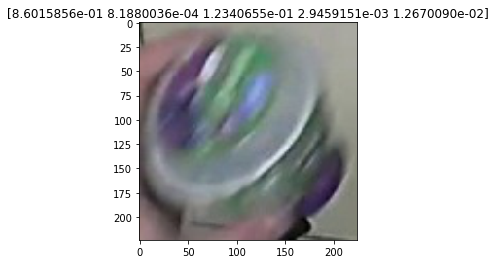

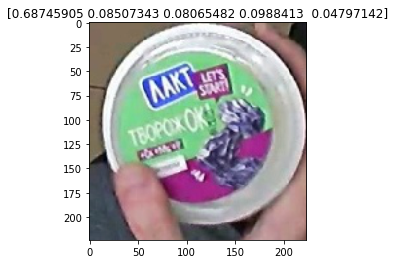

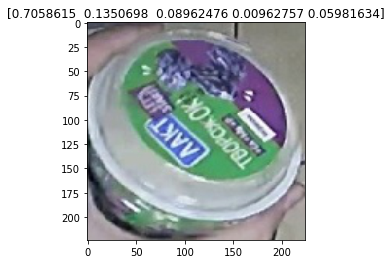

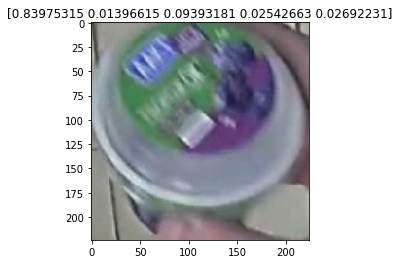

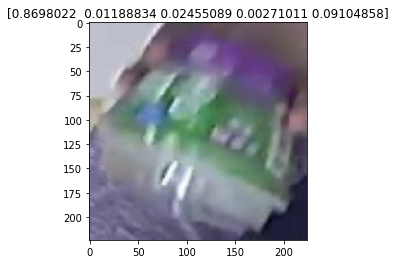

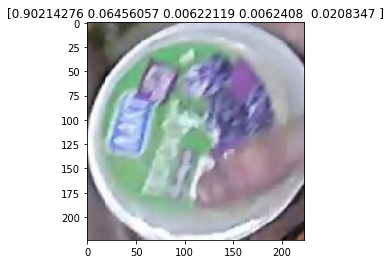

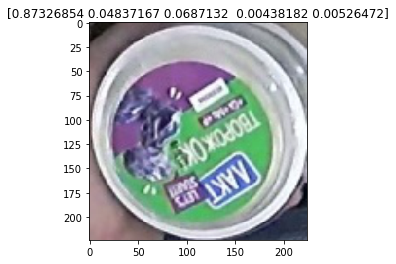

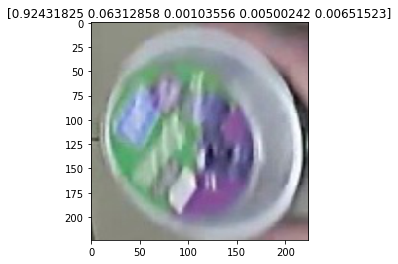

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df_1 = pd.DataFrame(test_predictions)

In [ ]:
submission_df_2 = pd.DataFrame.from_dict({'id': test_img_paths})

In [ ]:
submission_df_1[:5]

,0,1,2,3,4
0,0.860159,0.000819,0.123407,0.002946,0.012670
1,0.687459,0.085073,0.080655,0.098841,0.047971
2,0.705862,0.135070,0.089625,0.009628,0.059816
3,0.839753,0.013966,0.093932,0.025427,0.026922
4,0.869802,0.011888,0.024551,0.002710,0.091049


In [ ]:
submission_df_2[:5]

,id
0,test/unknown/35_curd_raisins/004857.jpg
1,test/unknown/35_curd_raisins/004867.jpg
2,test/unknown/35_curd_raisins/004868.jpg
3,test/unknown/35_curd_raisins/004871.jpg
4,test/unknown/35_curd_raisins/004877.jpg


In [ ]:
submission_df_3 = pd.concat([submission_df_2, submission_df_1], axis=1)

In [ ]:
submission_df_3[:5]

,id,0,1,2,3,4
0,test/unknown/35_curd_raisins/004857.jpg,0.860159,0.000819,0.123407,0.002946,0.012670
1,test/unknown/35_curd_raisins/004867.jpg,0.687459,0.085073,0.080655,0.098841,0.047971
2,test/unknown/35_curd_raisins/004868.jpg,0.705862,0.135070,0.089625,0.009628,0.059816
3,test/unknown/35_curd_raisins/004871.jpg,0.839753,0.013966,0.093932,0.025427,0.026922
4,test/unknown/35_curd_raisins/004877.jpg,0.869802,0.011888,0.024551,0.002710,0.091049
